<a href="https://colab.research.google.com/github/honghanhh/wqu_capstone_project_3621/blob/main/capstone_week6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>

# MScFE Capstone Project
### GROUP NUMBER: 3621



# BTC Price Prediction using Probabilistic Graphical Models for swing trading

</center>

# **1. Introduction**


The objective of this project is to develop a predictive model for Bitcoin (BTC) price using a Probabilistic Graphical Model (PGM). By leveraging the power of PGMs, we aim to identify the key sentiment, financial, technical, and on-chain factors that significantly influence the price of BTC. This analysis will provide valuable insights for swing traders looking to make informed trading decisions.

The project encompasses the following goals:

**Factor Identification**: We will carefully analyze a diverse set of sentiment, financial, technical, and on-chain metrics to identify the most influential factors affecting the price of BTC. By understanding these factors, we can gain deeper insights into the market dynamics.

**PGM Construction**: Using the identified factors, we will construct a sophisticated Probabilistic Graphical Model. This model will capture the complex relationships and dependencies among the factors, allowing us to make accurate predictions about future BTC price movements.

**Performance Comparison**:  To demonstrate the effectiveness of our approach, we will compare the performance of Markov Networks and Bayesian Networks in predicting prices. By evaluating and contrasting the results obtained from both models, our goal is to highlight the potential advantages and feasibility of each model in the context of swing trading.

By achieving these objectives, we seek to provide traders and investors with a valuable tool for making informed decisions in the dynamic and volatile world of cryptocurrency trading.

# **2. Import necessary libraries**

In [ ]:
# Install and import the required libraries
!pip install quandl
!pip install yfinance
!pip install pgmpy
!pip install "git+https://github.com/lopatovsky/HMMs.git"
!pip install pytrends
!pip install ta
!pip install coinmetrics-api-client
!pip install cryptocmd


# Import
import ta
import os
import copy
import hmms
import quandl

import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader as pdr
import pandas_datareader.data as web

from scipy import stats
from datetime import date
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.colors import Colormap, ListedColormap, BoundaryNorm
from coinmetrics.api_client import CoinMetricsClient
from cryptocmd import CmcScraper


import pylab as plb
import networkx as nx
from tqdm import tqdm
from pytrends.request import TrendReq
from pgmpy.models import BayesianNetwork
from pgmpy.models import MarkovNetwork, BayesianModel
from pgmpy.inference import BeliefPropagation
from pgmpy.estimators import BDeuScore, BDsScore, BicScore, HillClimbSearch, K2Score, BayesianEstimator

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# **3. Import data**

Our dataset covers a 10 year period from Jul 1, 2013, to July 1, 2023. It includes a set of variables that we believe to influence the price of Bitcoin. These variables are adjusted and supplemented based on the initial performance of our model. Our aim is to utilize a weekly timeframe for predicting BTC/USD prices.

The data collection encompasses four broad categories:

1. **Financial Data**: This includes data from the S&P500, Gold, 13-Week Treasury, and the USD Index. We sourced our financial data from Yahoo Finance.

2. **On-chain Data**: We included various on-chain variables such as hash rate, block difficulty, and transaction count. To acquire this data, we utilized the Coin Metrics API v4.

3. **Sentiment Data**: To gauge the sentiment surrounding Bitcoin, we utilized Google Trends data, specifically focusing on the word count associated with Bitcoin. The data collection for this category was done using the Google Trends Python API.

4. **Bitcoin Market Data**: This category encompasses Bitcoin candle and volume data. These indicators provide valuable insights into different dimensions of price momentum, trend analysis, volatility, and volume dynamics.

5. **Technical Indicators**: We include technical indicators to capture various aspects of Bitcoin's price behavior and market trends. The technical indicators we utilize include Simple Moving Average (SMA), Exponential Moving Average (EMA), Relative Strength Index (RSI), Volume-Weighted Average Price (VWAP),and On-Balance Volume (OBV). We use 'ta' library to compute these indicators.

By utilizing this robust data collection methodology, we aim to build a comprehensive model for Bitcoin price prediction.

In [ ]:
def data_extraction():
    end = date(2023, 7, 1)
    start = date(year=end.year-10, month=end.month, day=end.day)

    client = CoinMetricsClient()
    asset_metrics = client.get_asset_metrics(
        assets='btc',
        metrics=['PriceUSD', 'HashRate', 'DiffMean', 'TxCnt', 'CapMrktCurUSD'],
        start_time='2013-06-25T00:00:00Z',
        end_time=end
    )

    #################################
    # Crawl Bitcoin onchain dataset #
    #################################
    btc_onchain = asset_metrics.to_dataframe()
    btc_onchain = btc_onchain.rename(columns={
        'PriceUSD': 'btc_price',
        'HashRate': 'hash_ate',
        'DiffMean': 'block_difficulty',
        'TxCnt': 'transaction_count',
        'CapMrktCurUSD': 'market_cap'
    })

    # Convert the 'timestamp' column to datetime
    btc_onchain['Date'] = pd.to_datetime(btc_onchain['time'])
    btc_onchain.set_index('Date', inplace=True)

    # Drop the 'time' column
    btc_onchain.drop('time', axis=1, inplace=True)
    btc_onchain = btc_onchain.resample('W-MON').mean(numeric_only=True)

    # Convert datetime index to date (removes time component)
    btc_onchain.index = btc_onchain.index.date
    btc_onchain = btc_onchain[(btc_onchain.index >= start) & (btc_onchain.index <= end)]
    btc_onchain.index.name = 'Date'


    #############################################################
    # Crawl Financial data - S&P, Gold, 13W treasury, USD Index #
    #############################################################
    symbols = ['^GSPC','GC=F', '^IRX', 'DX-Y.NYB']
    financial_prices_df = pd.DataFrame()
    for symbol in symbols:
      try:
        data = yf.download(symbol, start=start, end=end, interval='1wk')['Adj Close']
        financial_prices_df[symbol] = data
      except:
        print(f"{symbol} not found on Yahoo Finance")


    # Rename columns for easier interpretation
    financial_prices_df = financial_prices_df.rename(columns={
        '^GSPC': 's&p500',
        'GC=F': 'gold',
        '^IRX': '13w_treasury',
        'DX-Y.NYB': 'usd_index'
    })

    #######################
    # Crawl Google Trends #
    #######################
    pytrends = TrendReq(hl='en-US', tz=360)
    keywords = ["Bitcoin", "BTC"]

    # Initialize a dataframe to store the results
    google_trends = pd.DataFrame()

    # Iterate over each year and fetch the weekly data
    for year in range(2013, 2024):
        pytrends.build_payload(
            kw_list=keywords,
            cat=0,
            timeframe=f'{year}-01-01 {year}-12-31'
        )
        data = pytrends.interest_over_time()
        google_trends = pd.concat([google_trends, data])

    google_trends = google_trends.resample('W-MON').sum()

    # Combine the 'Bitcoin' and 'BTC' columns
    google_trends['google_trends'] = google_trends['Bitcoin'] + google_trends['BTC']

    # Normalize the 'google_trends_BTC' column to a 0-100 scale as it provides normalized data
    google_trends['google_trends'] = ((google_trends['google_trends'] - google_trends['google_trends'].min()) /
                                          (google_trends['google_trends'].max() - google_trends['google_trends'].min())) * 100

    # Drop the original 'Bitcoin', 'BTC', and 'isPartial' columns
    google_trends.drop(columns=['Bitcoin', 'BTC', 'isPartial'], inplace=True)

    # Convert the index to datetime, filter, and then convert to date
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)
    google_trends.index = pd.to_datetime(google_trends.index)
    google_trends = google_trends[(google_trends.index >= start_date) & (google_trends.index <= end_date)]

    google_trends.index = google_trends.index.date
    google_trends.index.name = 'Date'


    #############################################################
    # Crawl BTC Open, high close, volume, marketCap data #
    #############################################################
    scraper = CmcScraper('BTC', '01-01-2013', '01-07-2023')
    # Transform collected data into a dataframe
    btc_ohlcv = scraper.get_dataframe()

    return btc_onchain, financial_prices_df, google_trends, btc_ohlcv

In [ ]:
# Reading csv data into dataframes
path = 'https://raw.githubusercontent.com/honghanhh/wqu_capstone_project_3621/main/historical_data/'
btc_onchain = pd.read_csv(path + 'btc_onchain_data.csv')
financial_data = pd.read_csv(path + 'financial_data.csv')
google_trends = pd.read_csv(path + 'google_trends.csv')
btc_ohlcv_daily = pd.read_csv(path + 'btc_ohlcv.csv')
## Remove btc price and marketcap from btc_onchain data as we use the data from btc_ohlcv df
btc_onchain = btc_onchain.drop(['btc_price', 'market_cap'], axis=1)
btc_onchain = btc_onchain.rename(columns={'has_ate': 'hash_rate'})

In [ ]:
def compute_indicators(df):
    df = df.copy()  # Create a copy of the input DataFrame
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    # Sort the DataFrame's index in ascending order
    df.sort_index(ascending=True, inplace=True)

    # Calculate SMA
    df['SMA'] = df['Close'].rolling(window=14).mean()

    # Calculate EMA
    df['EMA'] = df['Close'].ewm(span=14, adjust=False).mean()

    # Calculate RSI
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    ema_up = up.ewm(com=13, adjust=False).mean()
    ema_down = down.ewm(com=13, adjust=False).mean()
    rs = ema_up / ema_down
    df['RSI'] = 100 - (100 / (1 + rs))

    # Calculate VWAP
    df['VWAP'] = (df['Volume'] * df['Close']).cumsum() / df['Volume'].cumsum()

    # Calculate Average True Range (ATR)
    df['TR'] = pd.concat([
      abs(df['High'] - df['Low']),
      abs(df['High'] - df['Close'].shift(1)),
      abs(df['Low'] - df['Close'].shift(1))
      ], axis=1).max(axis=1, skipna=False)

    df['ATR'] = df['TR'].rolling(14).mean()

    # Calculate On-Balance Volume (OBV)
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

    df.reset_index()
    return df

btc_ohlcv_technical_daily = compute_indicators(btc_ohlcv_daily)

We transform our BTC price and technical indicator data from a daily timeframe to a weekly timeframe and filter it to cover a 10-year period starting from July 1, 2013 to July 1, 2023.


In [ ]:
def convert_to_weekly(df, end_date):
    df = df.copy()  # Create a copy of the input DataFrame
    #df['Date'] = pd.to_datetime(df['Date'])
    #df.set_index('Date', inplace=True)

    # Define your start and end dates
    end = pd.to_datetime(end_date)
    start = datetime(year=end.year-10, month=end.month, day=end.day)

    # Sort the DataFrame's index in ascending order
    df.sort_index(ascending=True, inplace=True)

    # Filter by date range
    df = df.loc[start:end]

    return df

# Use the function
end_date = '2023-07-01'
btc_ohlcv_technical = convert_to_weekly(btc_ohlcv_technical_daily, end_date)
btc_ohlcv_technical = btc_ohlcv_technical.reset_index()
btc_ohlcv_technical

,Date,Open,High,Low,Close,Volume,Market Cap,SMA,EMA,RSI,VWAP,TR,ATR,OBV
0,2013-07-01,97.510002,97.664902,86.297203,88.050003,0.000000e+00,1.000065e+09,102.687943,100.349353,27.921016,75.556985,11.367699,5.980979,3.580908e+06
1,2013-07-02,88.050003,92.300003,87.510002,90.134003,0.000000e+00,1.024082e+09,101.454657,98.987306,31.629206,75.556985,4.790001,5.603264,3.580908e+06
2,2013-07-03,90.404999,90.981201,76.979202,77.529999,0.000000e+00,8.812331e+08,99.260372,96.126332,23.690864,75.556985,14.001999,6.284121,3.580908e+06
3,2013-07-04,78.889999,83.105003,72.000000,80.525803,0.000000e+00,9.156186e+08,97.144357,94.046261,28.297315,75.556985,11.105003,6.591621,3.580908e+06
4,2013-07-05,79.989998,80.000000,65.526001,68.431000,0.000000e+00,7.784112e+08,94.210857,90.630893,22.414459,75.556985,14.999802,7.141250,3.580908e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3648,2023-06-27,30274.321188,31006.786577,30236.651294,30688.163854,1.642883e+10,5.957737e+11,28405.517016,29014.561456,70.313248,26869.193900,770.135283,1008.952488,1.108499e+12
3649,2023-06-28,30696.561487,30703.279976,29921.822833,30086.246189,1.457150e+10,5.841087e+11,28759.914838,29157.452754,64.049857,26870.075460,781.457144,983.367469,1.093928e+12
3650,2023-06-29,30086.186717,30796.250240,30057.203020,30445.351226,1.318086e+10,5.911079e+11,29107.697496,29329.172550,65.995986,26870.961463,739.047219,969.146506,1.107108e+12
3651,2023-06-30,30441.353759,31256.862700,29600.275939,30477.251282,2.638731e+10,5.917583e+11,29404.110988,29482.249714,66.171178,26872.749687,1656.586760,1000.487319,1.133496e+12


In our initial analyses, we identified the necessary variables based on our graph structure. Consequently, we eliminated the variables that were not incorporated within this structure to maintain a relevant and concise data set.

In [ ]:
# Define the columns to be removed
columns_to_remove = ['TR']

# Check if these columns exist in the dataframe and if so, remove them
btc_ohlcv_technical = btc_ohlcv_technical.drop(columns=[col for col in columns_to_remove if col in btc_ohlcv_technical.columns])

# Print the column names of the resulting dataframe
print(btc_ohlcv_technical.columns)

Index(['Date', 'Open', 'Close', 'Volume', 'Market Cap', 'SMA', 'EMA', 'RSI',
       'VWAP', 'ATR', 'OBV'],
      dtype='object')


We merge multiple datasets into a single dataframe to combine the relevant information for further analysis.

In [ ]:
# Define the function to merge on 'Date' column
def merge_dataframes_on_column(dataframes, column_name):
    df_merged = dataframes[0]  # Start with the first DataFrame in the list

    # Merge all other DataFrames in the list
    for df in dataframes[1:]:
        df_merged = pd.merge(df_merged, df, on=column_name)

    df_merged = df_merged.set_index(column_name)

    return df_merged

# List of dataframes
dataframes = [btc_onchain, financial_data, btc_ohlcv_technical, google_trends]

# Convert the 'Date' column to datetime for all dataframes
for i, df in enumerate(dataframes):
    df['Date'] = pd.to_datetime(df['Date'])
    dataframes[i] = df

# Merge the dataframes
df_data = merge_dataframes_on_column(dataframes, 'Date')

# Print the number of rows and columns in df_data
print(f"The DataFrame has {df_data.shape[0]} weekly data points (rows) and {df_data.shape[1]} variables (columns).")

df_data.head()

The DataFrame has 522 weekly data points (rows) and 19 variables (columns).


,block_size,block_difficulty,hash_ate,transaction_count,s&p500,gold,13w_treasury,usd_index,Open,Close,Volume,Market Cap,SMA,EMA,RSI,VWAP,ATR,OBV,google_trends
Date,,,,,,,,,,,,,,,,,,,
2013-07-01,117436.232199,2.003780e+07,162.859886,41551.857143,1631.890015,1212.900024,0.035,84.419998,97.510002,88.050003,0.0,1.000065e+09,102.687943,100.349353,27.921016,75.556985,5.980979,3580907.65,9.923664
2013-07-08,92162.669818,2.133533e+07,189.844708,35608.714286,1680.189941,1277.800049,0.030,82.989998,76.500000,76.515999,0.0,8.714579e+08,87.262100,84.853578,33.204718,75.556985,7.938328,3580907.65,7.633588
2013-07-15,111845.088323,2.479419e+07,210.214992,40125.428571,1692.089966,1293.300049,0.020,82.580002,93.605003,98.400200,0.0,1.123659e+09,83.944965,89.858967,55.426487,75.556985,9.346414,3580907.65,6.870229
2013-07-22,100241.984846,2.633047e+07,229.902273,37943.000000,1691.650024,1321.699951,0.015,81.620003,91.998001,91.610001,0.0,1.048939e+09,91.979465,91.396387,48.703652,75.556985,7.117443,3580907.65,8.396947
2013-07-29,114941.777846,3.125696e+07,252.380206,39327.571429,1709.670044,1310.599976,0.030,81.910004,98.599998,101.199997,0.0,1.161619e+09,94.894207,95.195364,58.696343,75.556985,4.640857,3580907.65,9.923664


# **4. Clean Data**

This section focuses on the process of data cleaning, which involves dealing with issues, including incorrect data, missing information, and unusual values.
- Bad data: we detect and replace incorrect data, such as negative or infinite asset values, with NaN values to maintain the accuracy of the dataset.
- Missing data: we address any gaps in the data by using the ffill (forward fill) and bfill (backward fill) methods to fill in missing values.
- Outliers: we use the z-score technique to identify and appropriately manage any extreme or unusual data points.

In [ ]:
def handle_bad_data(df):
    """
    Handle nan/null value from the dataset

    Parameters:
    df (pandas dataframe): The input dataframe.

    Returns:
    A cleaned dataframe with nan replaced by empty.
    """
    df[df <= 0] = np.nan
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.replace('', np.nan, inplace=True)

    return df

def handle_missing_data(prices: pd.DataFrame):
    """
    Handle missing value

    Parameters:
    df (pandas dataframe): The input dataframe.

    Returns:
    A cleaned dataframe with missing value filled using forward fill
    """
    # Forward fill the holes, by filling them with the data behind.
    prices_ffill = prices.fillna(method='ffill', inplace=False)
    prices_filled = prices_ffill.fillna(method='bfill', inplace=False)

    return prices_filled


def detect_outliers_zscore(df, threshold=3):
    """
    Detects and removes outliers from a pandas dataframe using z-score approach.

    Parameters:
    df (pandas dataframe): The input dataframe.
    threshold (float): The z-score threshold above which a data point is considered an outlier. Default is 3.

    Returns:
    A cleaned dataframe with outliers removed.
    """
    z_scores = stats.zscore(df)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < threshold).all(axis=1)
    cleaned_data = df[filtered_entries]

    return cleaned_data

In [ ]:
df_after_bad_data = handle_bad_data(df_data)
df_after_missing_data = handle_missing_data(df_after_bad_data)
data = detect_outliers_zscore(df_after_missing_data)
data.index = pd.to_datetime(data.index)
data['forecast'] = data['Close'].shift(-1)
data.head(5)

,block_size,block_difficulty,hash_ate,transaction_count,s&p500,gold,13w_treasury,usd_index,Open,Close,Volume,Market Cap,SMA,EMA,RSI,VWAP,ATR,OBV,google_trends,forecast
Date,,,,,,,,,,,,,,,,,,,,
2013-07-01,117436.232199,2.003780e+07,162.859886,41551.857143,1631.890015,1212.900024,0.035,84.419998,97.510002,88.050003,20707700.0,1.000065e+09,102.687943,100.349353,27.921016,75.556985,5.980979,3580907.65,9.923664,76.515999
2013-07-08,92162.669818,2.133533e+07,189.844708,35608.714286,1680.189941,1277.800049,0.030,82.989998,76.500000,76.515999,20707700.0,8.714579e+08,87.262100,84.853578,33.204718,75.556985,7.938328,3580907.65,7.633588,98.400200
2013-07-15,111845.088323,2.479419e+07,210.214992,40125.428571,1692.089966,1293.300049,0.020,82.580002,93.605003,98.400200,20707700.0,1.123659e+09,83.944965,89.858967,55.426487,75.556985,9.346414,3580907.65,6.870229,91.610001
2013-07-22,100241.984846,2.633047e+07,229.902273,37943.000000,1691.650024,1321.699951,0.015,81.620003,91.998001,91.610001,20707700.0,1.048939e+09,91.979465,91.396387,48.703652,75.556985,7.117443,3580907.65,8.396947,101.199997
2013-07-29,114941.777846,3.125696e+07,252.380206,39327.571429,1709.670044,1310.599976,0.030,81.910004,98.599998,101.199997,20707700.0,1.161619e+09,94.894207,95.195364,58.696343,75.556985,4.640857,3580907.65,9.923664,106.220001


In [ ]:
# Remove these variables and initial rows with 0 Volume
data.drop(['block_size', 'block_difficulty'], axis=1,inplace=True)
data = data[data['Volume'] != 0]
data

,hash_ate,transaction_count,s&p500,gold,13w_treasury,usd_index,Open,Close,Volume,Market Cap,SMA,EMA,RSI,VWAP,ATR,OBV,google_trends,forecast
Date,,,,,,,,,,,,,,,,,,
2013-07-01,1.628599e+02,41551.857143,1631.890015,1212.900024,0.035,84.419998,97.510002,88.050003,2.070770e+07,1.000065e+09,102.687943,100.349353,27.921016,75.556985,5.980979,3.580908e+06,9.923664,76.515999
2013-07-08,1.898447e+02,35608.714286,1680.189941,1277.800049,0.030,82.989998,76.500000,76.515999,2.070770e+07,8.714579e+08,87.262100,84.853578,33.204718,75.556985,7.938328,3.580908e+06,7.633588,98.400200
2013-07-15,2.102150e+02,40125.428571,1692.089966,1293.300049,0.020,82.580002,93.605003,98.400200,2.070770e+07,1.123659e+09,83.944965,89.858967,55.426487,75.556985,9.346414,3.580908e+06,6.870229,91.610001
2013-07-22,2.299023e+02,37943.000000,1691.650024,1321.699951,0.015,81.620003,91.998001,91.610001,2.070770e+07,1.048939e+09,91.979465,91.396387,48.703652,75.556985,7.117443,3.580908e+06,8.396947,101.199997
2013-07-29,2.523802e+02,39327.571429,1709.670044,1310.599976,0.030,81.910004,98.599998,101.199997,2.070770e+07,1.161619e+09,94.894207,95.195364,58.696343,75.556985,4.640857,3.580908e+06,9.923664,106.220001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-06,3.234787e+08,330076.000000,3861.590088,1862.000000,4.803,104.580002,22436.816776,22429.757533,1.735319e+10,4.331225e+11,23277.210650,23045.227296,43.497076,26856.576113,651.843298,1.044232e+12,65.648855,24197.532998
2023-03-13,3.234403e+08,319367.428571,3916.639893,1969.800049,4.293,103.709999,22156.406675,24197.532998,4.946636e+10,4.674174e+11,22238.048386,22272.412455,60.842903,26834.338573,880.726010,1.037912e+12,100.000000,27767.236332
2023-03-20,3.210338e+08,315454.857143,3970.989990,1982.099976,4.503,103.120003,28041.601917,27767.236332,4.477403e+10,5.365531e+11,23989.468118,25074.593253,70.211132,26831.236572,1422.782951,1.090748e+12,98.473282,27790.220855


# **5. Train validation test split**

We split the data into 80:10:10 ratio for training, validation, and testing.

In [ ]:
train_data = data[: int(data.shape[0] * 0.80)];
vald_data = data[int(0.80 * data.shape[0]) : int(0.90 * data.shape[0])];
test_data = data[int(0.90* data.shape[0]) : int(data.shape[0])];

# **6. Discretising data using Hidden Markov Models (HMMs)**

We utilize Hidden Markov Models (HMMs) to convert our continuous, unlabeled price data into discrete states representing different market conditions (bullish, bearish, or stagnant markets) and 2 output variables(increase or decrease). HMMs are graphical models designed for identifying hidden states within time-series data, and applying them allows us to transform our data into a set of states that capture market dynamics to be used in a Belief Network.

To ensure robust and optimal model training, we've implemented a strategy that involves multiple random initializations of our HMMs. For each time series, we initialize and train 10 different HMMs, each with a unique initial state. These models are then fitted to the data using the Baum-Welch algorithm, an expectation-maximization algorithm that iteratively estimates the parameters of the HMM to maximize the likelihood of the observed data. After training, each model's performance is evaluated based on the log-likelihood score. The model that yields the highest log-likelihood score is selected as the 'best' model for that particular time series. This approach helps us mitigate the risk of our optimization algorithm getting stuck in local optima, thereby increasing our chances of selecting a model that captures the underlying data dynamics more accurately.

Additionally, to expedite the model training process, we leverage concurrent programming techniques. Specifically, we use a ProcessPoolExecutor from Python's concurrent.futures module to train multiple models in parallel. This method takes advantage of the multiple cores present in modern processors, which allows for the simultaneous training of models on different time series, significantly improving the speed and efficiency of our model training process.

This combination of multiple random initializations, model selection based on log-likelihood, and parallel execution allows us to more effectively handle the complexity and scale of our data, and ultimately build more accurate and efficient market condition prediction models.

In [ ]:
from tqdm import tqdm
import os
import logging
import concurrent.futures
from functools import partial
import numpy as np
from scipy import stats

# Set up logging
logging.basicConfig(filename="training.log", level=logging.INFO)

def train_and_save_model(series_id, train_data):
    best_score = -np.inf
    best_model = None
    best_n_init = None
    best_n_iter = None
    best_n_states = None
    best_n_observables = None

    # Define range of n_init and n_iter values to try
    n_init_values = [10, 20, 30, 40, 50]
    n_iter_values = [100, 150, 200, 250, 300]

    # Define range of hidden states and observable states
    n_states_values = [2, 3, 4, 5]
    n_observables_values = [2, 3, 4, 5]

    data_diff = train_data[series_id].diff()[1:]
    bins = np.histogram_bin_edges(data_diff, bins='auto')  # Determine bin edges based on data
    emit_seq = np.digitize(data_diff, bins)  # Use digitize to get bin indices for each value

    for n_states in n_states_values:
        for n_observables in n_observables_values:
            for n_init in n_init_values:
                for n_iter in n_iter_values:
                    for i in range(n_init):
                        dhmm = hmms.DtHMM.random(n_states, n_observables)

                        # Try to fit the model to the data
                        try:
                            dhmm.baum_welch(emit_seq, n_iter)
                            score = dhmm.log_likelihood(emit_seq)

                            # If this model is better than the previous best, update best_score and best_model
                            if score > best_score:
                                best_score = score
                                best_model = dhmm
                                best_n_init = n_init
                                best_n_iter = n_iter
                                best_n_states = n_states
                                best_n_observables = n_observables
                        except Exception as e:
                            # If the model fails to fit the data, just skip it
                            logging.info(f"Training failed for series {series_id} on initialization {i} with error {str(e)}")
                            pass

    # If no model was successfully trained, create and save a random model
    if best_model is None:
        best_model = hmms.DtHMM.random(3,2)

    path = "./hmms/" + series_id.replace(".", "_")
    best_model.save_params(path)

    # Save log likelihood, best_n_init, best_n_iter, best_n_states, and best_n_observables
    with open(f"{path}_score.txt", "w") as f:
        f.write(f"Best score: {best_score}\nBest n_init: {best_n_init}\nBest n_iter: {best_n_iter}\nBest n_states: {best_n_states}\nBest n_observables: {best_n_observables}")

if not os.path.exists("./hmms"):
    os.makedirs("./hmms")

with concurrent.futures.ProcessPoolExecutor() as executor:
    series_ids = [col for col in train_data.columns if col != 'forecast']
    futures = {executor.submit(train_and_save_model, series_id, train_data) for series_id in series_ids}

    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Training models"):
        pass

Training models: 100%|██████████| 17/17 [05:50<00:00, 20.62s/it]


Once the HMMs have been trained for each time series, we apply a process of data discretization. For each series in our dataset, we load the corresponding trained HMM and apply it to the time series data. This is done by using the Viterbi algorithm which identifies the most likely sequence of hidden states (market conditions) given the observed data.

After obtaining the sequence of hidden states for each series, we store this discretized data into a new DataFrame. This transformed data now represents our original time series as a sequence of discrete market conditions to be used in Belief Networks.

In [ ]:
def discretise_data_with_hmm_and_save_csv(data, data_type):
  if not os.path.exists("./data"):
    os.makedirs("./data")

  disc_test = pd.DataFrame(index = data[1:].index)

  for series_id in data.columns:
    path = "./hmms/" + series_id.replace(".", "_") + ".npz"

    if series_id == 'forecast':
      dhmm = hmms.DtHMM.from_file('./hmms/Close.npz')
    else:
      dhmm = hmms.DtHMM.from_file(path)

    data_diff = data[series_id].diff()[1:]
    emit_seq = np.array(data_diff.apply(lambda x: 1 if x > 0 else 0).values)
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", category=DeprecationWarning)
    (log_prob, s_seq) = dhmm.viterbi(emit_seq)
    disc_test[series_id] = s_seq

  disc_test.to_csv(f'./data/{data_type}.csv')

discretise_data_with_hmm_and_save_csv(train_data, 'train_data')
discretise_data_with_hmm_and_save_csv(test_data, 'validation_data')
discretise_data_with_hmm_and_save_csv(test_data, 'test_data')

# **7.Regime switch plot**

Next, we illustrate the performance of our HMM model for identifying market regimes, by creating a series of color-coded time-series graphs for every asset, showing the regimes we've recognized. These graphs will help us visualize the precision with which we've identified the various market states. By examining the color-coded portions that represent each regime, we can get a better understanding of the effectiveness of our regime detection methodology.

In [ ]:
def plot_regime_switch(data, states, data_type):
  if not os.path.exists("./plots"):
    os.makedirs("./plots")

  for series_id in data.columns:
    df = pd.DataFrame(index=data[1:].index)
    df[series_id] = data[series_id][1:]
    df['Diff'] = data[series_id].diff()[1:]
    # index_diff = df.index.difference(states.index)
    df['Regime'] = states[series_id]

    # Get means of all assigned states
    means = df.groupby(['Regime'])['Diff'].mean()
    lst_1 = means.index.tolist()
    lst_2 = means.sort_values().index.tolist()
    map_regimes = dict(zip(lst_2, lst_1))
    df['Regime'] = df['Regime'].map(map_regimes)

    cmap = ListedColormap(['r','b','g'],'indexed')
    norm = BoundaryNorm(range(3 + 1), cmap.N)
    inxval = mdates.date2num(df[series_id].index)
    points = np.array([inxval, df[series_id]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(df['Regime'])
    plt.gca().add_collection(lc)
    plt.xlim(df[series_id].index.min(), df[series_id].index.max())
    plt.ylim(df[series_id].min(), df[series_id].max())
    r_patch = mpatches.Patch(color='red', label='Bear')
    g_patch = mpatches.Patch(color='green', label='Bull')
    b_patch = mpatches.Patch(color='blue', label='Stagnant')
    plt.legend(handles=[r_patch, g_patch, b_patch])
    name = f"./plots/{series_id.replace('.', '_')}_{'TRAIN'}.png"
    plt.savefig(name)
    plt.close()


states = pd.read_csv("./data/train_data.csv", index_col=0)
states.index = pd.to_datetime(states.index)
plot_regime_switch(train_data, states, 'TRAIN')

# **8.Bayesian Network Learning**

We chose to use the Hill Climb Search method to learn our Bayesian Network structure because it is more computationally feasible compared to other methods such as the PC (Constraint-Based Estimator) or Exhaustive Search.

While building the model, we will assess the algorithm's efficacy under a variety of scoring techniques. These include the Bayesian Information Criterion (BIC), Bayesian Dirichlet Equivalent Uniform (BDEU), Bayesian Dirichlet Score (BDS), and K2. The main objective of implementing these diverse scoring methods is to examine and contrast the algorithm's performance under each of these criteria. This comparison will offer valuable insights into the scoring method that would be most effective for our analysis.

In [ ]:
# Retrieve training set
train_data = pd.read_csv("./data/train_data.csv", index_col=0)

# Define scoring methods
scoring_methods = {
    "BicScore": BicScore(train_data),
    "BDeuScore": BDeuScore(train_data),
    "BDsScore": BDsScore(train_data)
}

def find_best_model(train_data, scoring_methods, max_iters):
    best_model = None
    best_score = float('-inf')
    best_method = None
    best_iter = None

    # Initialise Hill Climbing Estimator
    hc = HillClimbSearch(train_data)

    for max_iter in max_iters:
        for method_name, scoring_method in scoring_methods.items():
            print(f"Training with {method_name} and max_iter={max_iter}")
            model = hc.estimate(scoring_method=scoring_method, max_iter=max_iter)
            score = scoring_method.score(model)

            # Print the score for each method and iteration
            print(f"{method_name} score with max_iter={max_iter}: {score}")

            if score > best_score:
                best_score = score
                best_model = model
                best_method = method_name
                best_iter = max_iter

    return best_model, best_method, best_score, best_iter

# Use the function to find the best model
best_model, best_method, best_score, best_iter = find_best_model(train_data, scoring_methods, max_iters=[5, 10])

print(f"\nThe best method is {best_method} with max_iter={best_iter} and score {best_score}")
print(f"The best model nodes: {sorted(best_model.nodes())}")
print(f"The best model edges: {best_model.edges()}")

# Fit the Bayesian Network with the best model
model_bayesian = BayesianNetwork(ebunch=best_model.edges())
model_bayesian.fit(train_data)

Training with BicScore and max_iter=5


  0%|          | 0/5 [00:00<?, ?it/s]

BicScore score with max_iter=5: -5453.884478658603
Training with BDeuScore and max_iter=5


  0%|          | 0/5 [00:00<?, ?it/s]

BDeuScore score with max_iter=5: -5444.2132723156155
Training with BDsScore and max_iter=5


  0%|          | 0/5 [00:00<?, ?it/s]

BDsScore score with max_iter=5: -5553.730526844087
Training with BicScore and max_iter=10


  0%|          | 0/10 [00:00<?, ?it/s]

BicScore score with max_iter=10: -5441.963036802022
Training with BDeuScore and max_iter=10


  0%|          | 0/10 [00:00<?, ?it/s]

BDeuScore score with max_iter=10: -5420.932441648949
Training with BDsScore and max_iter=10


  0%|          | 0/10 [00:00<?, ?it/s]

BDsScore score with max_iter=10: -5535.672335362975

The best method is BDeuScore with max_iter=10 and score -5420.932441648949
The best model nodes: ['13w_treasury', 'ATR', 'Close', 'EMA', 'Market Cap', 'OBV', 'Open', 'RSI', 'SMA', 'VWAP', 'Volume', 'forecast', 'gold', 'google_trends', 'hash_ate', 's&p500', 'transaction_count', 'usd_index']
The best model edges: [('gold', 'usd_index'), ('Open', 'Close'), ('Open', 'OBV'), ('Close', 'forecast'), ('Close', 'Market Cap'), ('Market Cap', 'EMA'), ('Market Cap', 'Volume'), ('EMA', 'SMA'), ('RSI', 'VWAP'), ('google_trends', 'VWAP')]


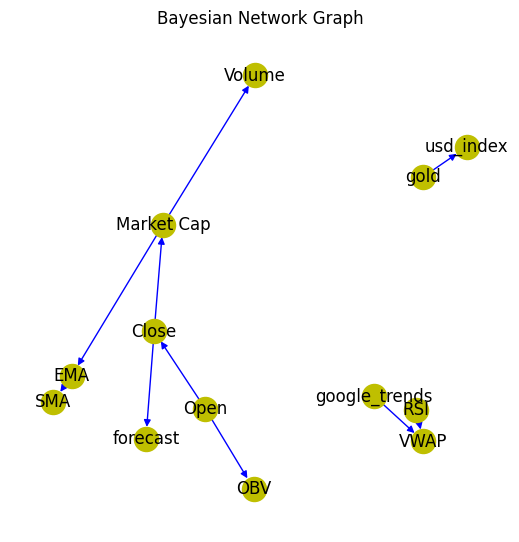

In [ ]:
#Create a figure
fig = plt.figure(figsize=(5, 5))

#Plot K2_model
G1 = nx.DiGraph()
G1.add_edges_from(model_bayesian.edges())
pos1 = nx.spring_layout(G1, iterations=20)
nx.draw(G1, node_color='y', with_labels=True, edge_color='b', font_weight=0.5)
plt.title('Bayesian Network Graph')

#Show the plot
plt.show()

In [ ]:
model_bayesian.get_markov_blanket('Close')

['forecast', 'Market Cap', 'Open']

The provided graph visually represents the relationships between various variables and the closing price of Bitcoin (BTC) in our Bayesian network model. Notably, several variables - including gold, USD index, VWAP, Google Trends, and the Relative Strength Index (RSI) - did not establish any connections with the closing price. This suggests that these variables did not contribute significantly to predicting the closing price of BTC according to our model.

On the other hand, a group of variables - namely, the Simple Moving Average (SMA), Exponential Moving Average (EMA), Market Cap, Volume, Opening Price, and On-Balance Volume (OBV) - formed a connected subgraph with the closing price. This implies that these variables play a crucial role in predicting BTC's closing price within our Bayesian network model.

Furthermore, the direct edge from the Opening Price to the Closing Price indicates a strong predictive relationship between these two variables. According to our model, the Opening Price is a significant predictor of the Closing Price for Bitcoin.

In [ ]:
|import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def predict_value(model_struct, states):
    """
    Predicts the value for a given model and states.

    Parameters:
    model_struct (BayesianModel): The trained model.
    states (pd.DataFrame): The states data.

    Returns:
    pred_value (np.array): The predicted value.
    """
    try:
        column_names_df1 = set(model_struct.nodes())
        column_names_df2 = set(states.columns)
        columns_only_in_df2 = column_names_df2 - column_names_df1

        data_new = states.drop(columns=list(columns_only_in_df2) + ['forecast'], axis=1)

        logging.info(f'data_new columns: {data_new.columns}')
        logging.info(f'model nodes: {model_struct.nodes()}')

        prediction = model_struct.predict(data_new)
        pred_value = prediction['forecast'].to_numpy()
        print(f'Predicted value: {pred_value}')

        return pred_value

    except Exception as e:
        logging.error("Failed to predict values with error: %s", e)

def calculate_error(pred_value, real):
    """
    Calculates the error between predicted and real values.

    Parameters:
    pred_value (np.array): The predicted values.
    real (np.array): The real values.

    Returns:
    error (float): The error value.
    """
    try:
        error = np.mean(real != np.roll(pred_value, 1))
        print(f'\nError: {error * 100}%')
        logging.info(f'Error: {error * 100} %')

        return error

    except Exception as e:
        logging.error("Failed to calculate error with error: %s", e)

### **Model Validation**

We validate our model on the validation data set to ensure the viability of our model.

In [ ]:
## Discretise the validation dataset and plot
discretise_data_with_hmm_and_save_csv(vald_data,'validation_data')
states_validation = pd.read_csv("./data/validation_data.csv", index_col=0)
states_validation.index = pd.to_datetime(states_validation.index)
plot_regime_switch(vald_data, states_validation, 'VALIDATION')

# Record real data observation, to be compared with the predicted one
validation_real = states_validation['Close'].to_numpy()

prediction_validation_bayesian = predict_value(model_bayesian,states_validation)
error_vald_bayesian = calculate_error(prediction_validation_bayesian,validation_real)

  0%|          | 0/47 [00:00<?, ?it/s]

Predicted value: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1]

Error: 4.25531914893617%


# **9. Markov Network Construction**

In this section, we use the learnt Bayesian Network as the basis for the Markov network. We remove any disconnected nodes from the Bayesian Network. Disconnected nodes would imply isolated subsystems that do not interact with the rest of the network, which could disrupt our subsequent analysis.

Once we have a connected Bayesian network, we convert it into a Markov network. The Markov network allows us to represent the joint probability distribution of our set of variables, providing a robust way of capturing complex dependencies among multiple variables.

After establishing the Markov network, we apply the Belief Propagation algorithm. This algorithm performs inference on our network by propagating probabilities throughout the network. It calculates the marginal distribution for each unobserved node given the observed nodes.  By doing this, we can make probabilistic predictions about unknown variables based on the values of known variables. In the context of our project, we specifically use this approach to make predictions on the closing price of Bitcoin (BTC).

In [ ]:
def remove_disconnected_nodes(original_model: BayesianModel) -> BayesianModel:
    """
    Function to remove disconnected nodes from a Bayesian Model.
    It returns a new Bayesian Model, leaving the original one untouched.
    """
    model = original_model.copy()

    # Convert the model to an undirected graph
    undirected = model.to_undirected()

    # Get the list of connected components, sorted by size
    connected_components = sorted(list(nx.connected_components(undirected)), key=len, reverse=True)

    # Keep only the largest connected component
    largest_component = connected_components[0]

    # Get a list of nodes in the smaller components
    nodes_to_remove = [node for component in connected_components[1:] for node in component]

    # Remove the nodes in the smaller components from the original directed graph
    for node in nodes_to_remove:
        model.remove_node(node)

    return model

model_bayesian_connected = remove_disconnected_nodes(model_bayesian)

# Convert Bayesian Network to Markov Network
markov_model = model_bayesian_connected.to_markov_model()

# Initialize the Belief Propagation class with the Markov Model
bp = BeliefPropagation(markov_model)

for cpd in model_bayesian_connected.get_cpds():
    print("CPD for {0}:".format(cpd.variable))
    print(cpd)

CPD for Open:
+---------+-----------+
| Open(0) | 0.84375   |
+---------+-----------+
| Open(1) | 0.148438  |
+---------+-----------+
| Open(2) | 0.0078125 |
+---------+-----------+
CPD for Close:
+----------+----------------------+----------------------+--------------------+
| Open     | Open(0)              | Open(1)              | Open(2)            |
+----------+----------------------+----------------------+--------------------+
| Close(0) | 0.904320987654321    | 0.2631578947368421   | 0.0                |
+----------+----------------------+----------------------+--------------------+
| Close(1) | 0.08641975308641975  | 0.7192982456140351   | 0.6666666666666666 |
+----------+----------------------+----------------------+--------------------+
| Close(2) | 0.009259259259259259 | 0.017543859649122806 | 0.3333333333333333 |
+----------+----------------------+----------------------+--------------------+
CPD for OBV:
+--------+---------------------+---------------------+----------------

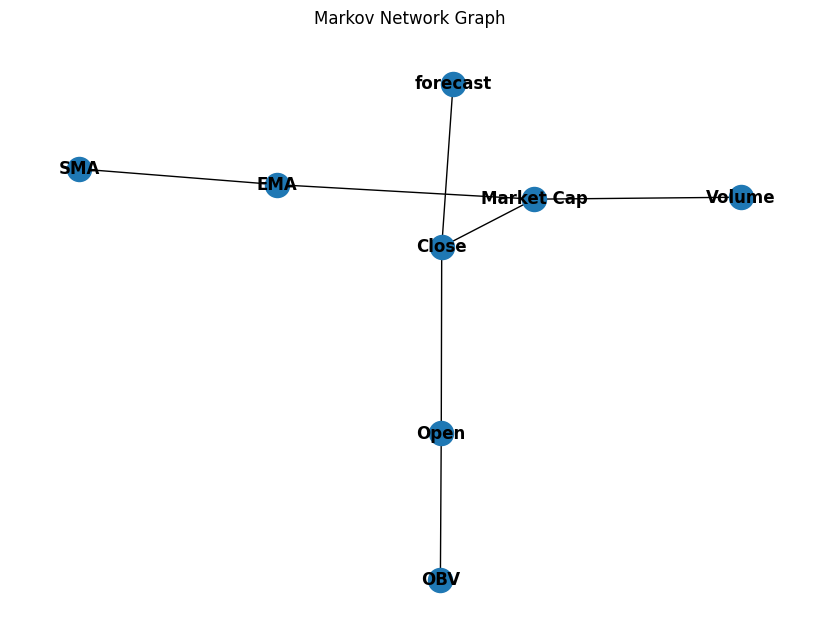

In [ ]:
# Create a new graph from the Markov model's edges
G = nx.Graph()
G.add_edges_from(markov_model.edges())

# Draw the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)  # set layout
nx.draw(G, pos, with_labels=True, font_weight='bold')

plt.title('Markov Network Graph')
plt.show()

### **Inference with Belief Propogation**

After discretising our test  data, We then conduct a series of inferences across the entire test dataset. For each data point, we create a set of evidence based on the available variables, excluding the target variable, which is the Bitcoin closing price in our case. Using this evidence, we perform inference using the Belief Propagation algorithm on our Markov model, querying for the probability distribution of the possible states of the closing price.

Each result, which is a probability distribution over possible states, is stored in a DataFrame. Furthermore, we generate a forecast for each data point by selecting the state with the highest probability.

Finally, we compile our results, which include the predicted probabilities, forecasted state, and actual closing price for each data point in our test dataset. This forms the basis for our subsequent evaluation of the Markov model's performance in predicting Bitcoin prices.

In [ ]:
from pandas.core.arrays.datetimelike import mode

# discretise test data and plot
discretise_data_with_hmm_and_save_csv(test_data, 'test_data')
states_test = pd.read_csv("./data/test_data.csv", index_col=0);
# states_test = states_test.drop('forecast', axis=1)

# Initialize an empty DataFrame to store the results
results_df_markov = pd.DataFrame()

# Get a set of variable names from the model
model_variables = set(model_bayesian_connected.nodes())
print(model_variables)

# Loop over all rows in the DataFrame
for i in range(len(states_test)):
    # Get the current row and convert it to a dictionary
    evidence_row = test_data.iloc[i]
    evidence = evidence_row.to_dict()

    # # Remove 'Close' and forecast from the evidence
    if 'Close' in evidence:
        del evidence['Close']
        # del evidence['forecast']
        # del evidence['13w_treasury']

    # Only keep variables in the evidence that are in the model
    evidence = {var: value for var, value in evidence.items() if var in model_variables and value in [0, 1, 2]}
    # for var, value in evidence.items():
    #   print(f"Variable: {var}, Value: {value}, Type: {type(value)}")

    # Perform the inference
    result = bp.query(variables=['Close'], evidence=evidence)

    # Convert the result to a DataFrame and append it to the results DataFrame
    result_df = pd.DataFrame([result.values], columns=['prob_0', 'prob_1', 'prob_2'])
    results_df_markov = pd.concat([results_df_markov, result_df], ignore_index=True)

results_df_markov['forecast'] = np.argmax(results_df_markov.values, axis=1)
# results_df = results_df.reset_index(drop=True)
test_dataset = states_test.reset_index(drop=True)
results_df_markov['Close'] = test_dataset['Close']
results_df_markov

# **10. Model Testing**

In this section we test our models and compare their performance.

###**Baysian Network**

In [ ]:
# discretise test data and plot
states_test = pd.read_csv("./data/test_data.csv", index_col=0);
states_test.index = pd.to_datetime(states_test.index)

# Record real data observation, to be compared with the predicted one
test_real = states_test['Close'].to_numpy();
print("\nReal Value: ");
print(test_real);

prediction_test_bayesian = predict_value(model_bayesian,  states_test)
error_test_bayesian = calculate_error(prediction_test_bayesian,test_real)


Real Value: 
[1 1 1 1 1 2 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]


  0%|          | 0/48 [00:00<?, ?it/s]

Predicted value: [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]

Error: 6.25%


###**Markov Network**

In [ ]:
prediction_test_markov = results_df_markov['forecast'].to_numpy()
real_values = results_df_markov['Close'].to_numpy()
print(f'Real values: \n {real_values}')
print(f'Predicted values: \n {prediction_test_markov}')
error_test_markov = calculate_error(prediction_test_markov,real_values)

Real values: 
 [1 1 1 1 1 2 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
Predicted values: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]

Error: 18.75%


# **10. Model Evaluation & Comparison**

In this section, we implement a trading strategy based on the forecasts produced by either the Bayesian and Markov model. The strategy starts with no cash and one unit of the asset.

We iterate over each data point in our test dataset. If the forecast for the previous day is a 'sell' signal (represented by 0) and we hold some units of the asset, we sell all our holdings at the current day's closing price and convert it into cash. If the forecast for the previous day is a 'buy' signal (represented by 2) and we have some cash, we use all our cash to buy the asset at the current day's closing price. If the forecast is a 'hold' signal (represented by 1), we do nothing and move to the next day.

We keep track of the number of trades executed, the value of our holdings, and the cash at hand. At each step, the total value is calculated as the sum of the value of the holdings (quantity of the asset held times its current price) and the cash in hand.

The strategy thus generates a series of trades based on the model's forecasts, and the resultant changes in the portfolio's cash, holdings, and total value are recorded. By comparing these results with the actual price changes, we can evaluate the performance of our trading strategy as guided by the Bayesian and Markov model predictions.

Number of trades with Bayesian Model: 1
Number of trades with Markov Model: 1


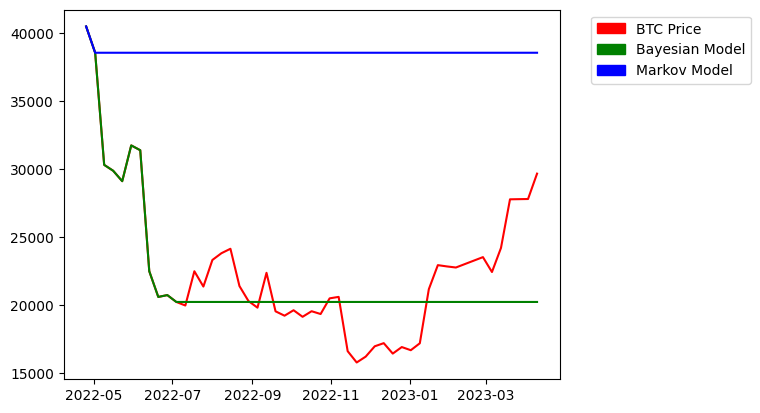

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def trading_strategy(test_sheet, model_type, forecast_col):
    # Check the model type
    if model_type not in ['bayesian', 'markov']:
        raise ValueError("model_type must be either 'bayesian' or 'markov'")

    test_sheet = test_sheet.copy()

    # Initialize columns for holding data and a counter for trades
    test_sheet[f'{model_type}_holdings'] = 0.0
    test_sheet[f'{model_type}_cash'] = 0.0
    test_sheet[f'{model_type}_total'] = 0.0
    num_trades = 0

    # Initialize cash and holdings
    initial_cash = 0.0  # Start with no cash
    cash = initial_cash
    holdings = 1.0  # Start with 1 unit of the asset

    # Update the first row
    test_sheet[f'{model_type}_holdings'].iloc[0] = holdings * test_sheet['Close'].iloc[0]
    test_sheet[f'{model_type}_cash'].iloc[0] = cash
    test_sheet[f'{model_type}_total'].iloc[0] = test_sheet[f'{model_type}_holdings'].iloc[0] + test_sheet[f'{model_type}_cash'].iloc[0]

    # Loop through each row starting from the second row
    for i in range(1, len(test_sheet)):
        # Sell
        if test_sheet[forecast_col].iloc[i-1] == 0 and holdings > 0:  # Signal to sell
            cash += holdings * test_sheet['Close'].iloc[i]
            holdings = 0.0
            num_trades += 1  # Increase the trade counter

        # Buy
        elif test_sheet[forecast_col].iloc[i-1] == 2 and cash > 0:  # Signal to buy
            holdings += cash / test_sheet['Close'].iloc[i]
            cash = 0.0
            num_trades += 1  # Increase the trade counter

        # Update dataframe
        test_sheet[f'{model_type}_holdings'].iloc[i] = holdings * test_sheet['Close'].iloc[i]
        test_sheet[f'{model_type}_cash'].iloc[i] = cash
        test_sheet[f'{model_type}_total'].iloc[i] = test_sheet[f'{model_type}_holdings'].iloc[i] + test_sheet[f'{model_type}_cash'].iloc[i]

    return test_sheet, num_trades

test_data = data[int(0.90* data.shape[0]) : int(data.shape[0])];
test_sheet = pd.DataFrame(index=test_data.index[1:])  # exclude the first row
test_sheet['Close'] = test_data['Close'].iloc[1:].to_numpy()

# Add separate 'forecast' columns for Bayesian and Markov predictions
test_sheet['bayesian_forecast'] = prediction_test_bayesian
test_sheet['markov_forecast'] = prediction_test_markov

# Perform trading strategy with Bayesian model predictions
test_sheet, num_trades_bayesian = trading_strategy(test_sheet, 'bayesian', 'bayesian_forecast')
print(f"Number of trades with Bayesian Model: {num_trades_bayesian}")

# Perform trading strategy with Markov model predictions
test_sheet, num_trades_markov = trading_strategy(test_sheet, 'markov', 'markov_forecast')
print(f"Number of trades with Markov Model: {num_trades_markov}")

plt.plot(test_sheet.index, test_sheet['Close'], 'r');
plt.plot(test_sheet.index, test_sheet['bayesian_total'], 'g');
plt.plot(test_sheet.index, test_sheet['markov_total'], 'b');

r_patch = mpatches.Patch(color='red', label='BTC Price')
g_patch = mpatches.Patch(color='green', label='Bayesian Model')
b_patch = mpatches.Patch(color='blue', label='Markov Model')

plt.legend(handles=[r_patch, g_patch, b_patch], bbox_to_anchor=(1.05, 1), loc='upper left')

The above graph illustrates the performance of our two strategies - the Bayesian model and the Markov model - over specific time periods. It is evident that both strategies managed to hedge against downside risk effectively for certain durations.

The Bayesian model demonstrated its capability to protect against downside risk during the period from November 2022 to January 2023. However, it was unable to sustain this protective effect beyond this timeframe.

Contrastingly, the Markov model showcased a robust performance by hedging against downside risk throughout the entire test period from May 2022 to March 2023. Its ability to protect against downside risk throughout this period enabled the Markov model to prevent any losses due to market downturns.

However, the Bayesian model's performance was not as satisfactory. In fact, it underperformed the simple buy-and-hold strategy, leading to higher losses. This suggests that, within the context of our study, the Markov model demonstrated a superior capability to manage risk and protect against market downturns compared to the Bayesian model.

In [ ]:
def get_stats(returns: pd.Series, risk_free_rate: float = 0.0) -> dict:
    """
    Calculate relevant financial statistics for a given return series.

    Args:
        returns (pd.Series): The return series to analyze.
        risk_free_rate (float): The risk-free rate for Sharpe and Sortino ratios. Default is 0.0.

    Returns:
        dict: A dictionary containing computed financial statistics.
    """
    stats = {}

    # Total Returns
    stats['total returns'] = (np.exp(returns.sum()) - 1) * 100

    # Mean Annual Returns
    stats['annual returns'] = (np.exp(returns.mean() * 252) - 1) * 100

    # Annual Volatility
    stats['annual volatility'] = returns.std() * np.sqrt(252) * 100

    # Sharpe Ratio
    stats['sharpe ratio'] = ((stats['annual returns'] / 100) - risk_free_rate) / (stats['annual volatility'] / 100)

    # Max Drawdown
    cum_returns = (1 + returns).cumprod()
    running_max = np.maximum.accumulate(cum_returns)
    drawdown = (cum_returns)/running_max - 1
    stats['max drawdown'] = drawdown.min() * 100

    # Max Drawdown Duration
    underwater = drawdown < 0
    underwater_periods = underwater.cumsum() - np.maximum.accumulate(underwater * (1 - underwater).cumsum())
    stats['max drawdown duration'] = underwater_periods.max()

    return stats

In [ ]:
# Calculate returns
test_sheet['actual_returns'] = np.log(test_sheet['Close'] / test_sheet['Close'].shift(1))
test_sheet['returns_bayesian'] = np.log(test_sheet['bayesian_total'] / test_sheet['bayesian_total'].shift(1))
test_sheet['returns_markov'] = np.log(test_sheet['markov_total'] / test_sheet['markov_total'].shift(1))

# Calculate metrics
actual_stats = get_stats(test_sheet['actual_returns'].dropna())
predicted_bayesian_stats = get_stats(test_sheet['returns_bayesian'].dropna())
predicted_markov_stats = get_stats(test_sheet['returns_markov'].dropna())

# Convert the dictionaries to dataframes
actual_stats_df = pd.DataFrame.from_dict(actual_stats, orient='index', columns=['Actual'])
predicted_bayesian_stats_df = pd.DataFrame.from_dict(predicted_bayesian_stats, orient='index', columns=['Bayesian'])
predicted_markov_stats_df = pd.DataFrame.from_dict(predicted_markov_stats, orient='index', columns=['Markov'])

# Concatenate the dataframes side by side
stats_table = pd.concat([actual_stats_df, predicted_bayesian_stats_df, predicted_markov_stats_df], axis=1)
stats_table_rounded = stats_table.round(2)
print(stats_table_rounded)

                       Actual  Bayesian  Markov
total returns          -26.71    -49.99   -4.77
annual returns         -81.10    -97.57  -23.04
annual volatility      148.90     98.64   11.31
sharpe ratio            -0.54     -0.99   -2.04
max drawdown           -65.92    -53.19    0.00
max drawdown duration   45.00     45.00    0.00


The results from our study comparing the Bayesian and Markov models against the actual market performance yield several key insights.

In terms of total returns, the Markov model outperformed both the Bayesian model and the actual market performance, registering a return of -4.77%, which is a considerably lower loss compared to the -49.99% from the Bayesian model and -26.71% from the actual market.

When we examine annual returns, we observe a similar trend, with the Markov model exhibiting a significantly smaller loss of -23.04% compared to both the -97.57% from the Bayesian model and -81.10% from the actual market performance.

Looking at annual volatility, which measures the degree of variation in trading prices over a year, the Markov model, with an annual volatility of 11.31%, demonstrated a significantly lower volatility than the actual market's 148.90% and the Bayesian model's 98.64%. This suggests a higher level of stability in the Markov model's performance.

The Sharpe ratio, a measure of risk-adjusted return, was negative for all three scenarios. However, the Markov model's ratio of -2.04 was lower than the Bayesian model's -0.99 and the actual market's -0.54, indicating a lower risk-adjusted performance.

In terms of maximum drawdown, which measures the largest single drop from peak to bottom in the value of a portfolio, the Markov model showcased strong resilience with no drawdowns (0.00%). This is a marked contrast to the significant drawdowns experienced by the Bayesian model (-53.19%) and the actual market (-65.92%).

Finally, regarding the maximum drawdown duration, the Markov model demonstrated a high level of resilience by recovering immediately from any losses (0.00 days), compared to the 45-day recovery period for both the Bayesian model and the actual market.

In summary, the Markov model demonstrated superior performance in terms of total and annual returns, annual volatility, maximum drawdown, and maximum drawdown duration. However, its risk-adjusted return, as measured by the Sharpe ratio, was lower than that of the Bayesian model and the actual market.